In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# MCMC Regeneration Techniques

## Alternative Approach by Mykland et al.

Mykland et al. (1995) proposed an alternative approach based on a less restrictive representation of renewal called "regeneration". This technique is also discussed in Gilks et al. (1998) and Nummelin (1998, 2003).

The use of small sets is obviously relevant in the context of convergence of averages, as presented in Section 12.3.3, and a correct discretization technique, see Section 12.4.2, but it is above all a central notion for the convergence to stationarity.

As we will see in Chapter 13, renewal is key to the derivation of perfect sampling schemes (see Section 13.2.4), in which we can obtain exact samples from the stationary distribution. This is done using Aït's *representation of stationary distributions* (Section 6.5.2). Practicalities with integration con-dilution, namely the derivation of the minorizing measure and the very small probability of renewal, remain, however, and restrict the practicality of this approach for actual applications.

Mykland et al. (1995) exploited small sets and the corresponding minorization condition with a generalization through functions $s$ such that:

$$P(g^{(t+1)} \in B|g^{(t)}) = s(g^{(t)}) \nu(B)$$

where $g^{(t)} \in E, B \in \mathcal{E}(E)$. Small sets thus correspond to the particular case of $s_E(x) = \mathbf{1}_E(x)$. If we define:

$$r(g^{(t)}, \xi) = \frac{s(g^{(t)}) \nu(\xi)}{K(g^{(t)}, \xi)}$$

then each time $t$ is a renewal time with probability $r(g^{(t-1)}, \xi)$.

Based on the regeneration rate, Mykland et al. (1995) propose a graphical convergence assessment. When an MCMC algorithm is in the stationary regime and has correctly explored the support of $f$, the regeneration rate must remain approximately constant (because of stationarity). Thus, they plot an approximation of the regeneration rate:

$$\hat{r}_T = \frac{1}{T} \sum_{t=1}^T r(g^{(t)}, g^{(t+1)})$$

against $T$. When the normalizing constant of $\nu$ is available they instead plot:

$$\hat{r}_T = \frac{1}{T} \sum_{t=1}^T s(g^{(t)})$$

An additional recommendation of the authors is to smooth the graph of $\hat{r}_T$ by nonparametric techniques, but the variance of the smoothing parameter must be assessed to avoid overoptimistic conclusions (see Section 12.6.1 for a global criticism of functional nonparametric techniques).

Stephens and Smith (1993) provide a critical discussion of the regeneration method, since they allow for complete freedom in the choice of the transition kernel $P$. Problems related to the hysteresis of the kernel can be eliminated by considering only its absolutely continuous part:

$$P(g^{(t)}, \xi) q(g^{(t)}) = \min\left\{\frac{f(\xi)}{f(g^{(t)})} \nu(g^{(t)}|\xi), \nu(g^{(t)}|\xi)\right\}$$

using the notation of [A.24]. The determination of $s$ and $\nu$ is facilitated in the case of a so-called pseudo-reversible transition; that is, when there exists a reversion function $\bar{f}$ with:

$$\bar{f}(\theta) q(g|\theta) = f(\xi) q(\theta|\xi)$$

Equation (12.5) thus looks like a detailed balance condition for a reversible Markov chain, but $\bar{f}$ is not necessarily a probability density.

## Lemma 12.5

Suppose that $q$ satisfies (12.5) and for the transition induced by $q$, the functions $s$ and $\nu_\xi$ satisfy (12.4). Let $u(\theta) = f(\theta)/\bar{f}(\theta)$ and for every $c > 0$, define the function:

$$s(\theta) = s_\xi(\theta) \min\left\{\frac{c}{u(\theta)}, 1\right\}$$

and the density:

$$\nu(\theta) = \nu_\xi(\theta) \min\left\{\frac{u(\theta)}{c}, 1\right\}$$

then, for the Metropolis-Hastings algorithm associated with $q$, $s(\theta)$ and $\nu(\theta)$ satisfy (12.4).

### Proof

Since:

$$P(g^{(t+1)} \in B|g^{(t)}) \geq \int_B P(g^{(t)}, \xi) q(g^{(t+1)}|\xi) d\xi$$

we have:

$$P(g^{(t+1)} \in B|g^{(t)}) \geq \int_B \min\left\{\frac{u(g^{(t)})}{u(\xi)}, 1\right\} q(g^{(t+1)}|\xi) d\xi$$

$$\geq \min\left\{\frac{u(g^{(t)})}{c}\right\} \int_B \min\left\{\frac{c}{u(\xi)}, 1\right\} q(g^{(t+1)}|\xi) d\xi$$

$$= s(g^{(t)}) \int_B \nu(\xi) d\xi$$

In the particular case of an independent Metropolis-Hastings algorithm, $q(g|\theta) = q(g)$ and (12.5) applies for $\bar{f} = q$. Therefore, $s_\xi = 1$, $\nu_\xi = q$, and:

$$\nu(\xi) \propto q(\xi) \min\left\{\frac{f(\xi)}{c q(\xi)}, 1\right\} \propto \min\{f(\xi), cq(\xi)\}$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

class MCMCRegenerationDiagnostics:
    """
    Implementation of MCMC regeneration techniques following Mykland et al. (1995)
    for monitoring convergence and assessing mixing of Markov chains.
    """
    
    def __init__(self, samples, target_density, proposal_density=None):
        """
        Initialize the regeneration diagnostics.
        
        Parameters:
        -----------
        samples : array-like
            MCMC samples from the target distribution
        target_density : callable
            Function that evaluates the target density (up to a constant)
        proposal_density : callable, optional
            Function that evaluates the proposal density. If None, assumes
            independent Metropolis-Hastings was used.
        """
        self.samples = np.asarray(samples)
        self.target_density = target_density
        self.proposal_density = proposal_density
        self.n_samples = len(samples)
        
    def calculate_s_function(self, theta, c=None):
        """
        Calculate the s function for a given theta as described in Lemma 12.5.
        
        For independent Metropolis-Hastings, s_ξ = 1, so:
        s(θ) = min{c/u(θ), 1}, where u(θ) = f(θ)/q(θ)
        
        Parameters:
        -----------
        theta : array-like
            Parameter value
        c : float, optional
            Tuning parameter for the s function. If None, will be estimated.
            
        Returns:
        --------
        float : s(θ) value
        """
        if self.proposal_density is None:
            raise ValueError("Proposal density must be provided for s function calculation")
            
        # If c is not provided, estimate it based on the samples
        if c is None:
            ratios = np.array([self.target_density(s) / self.proposal_density(s) 
                              for s in self.samples])
            c = np.median(ratios)  # A reasonable heuristic
            
        u_theta = self.target_density(theta) / self.proposal_density(theta)
        return min(c / u_theta, 1)
    
    def calculate_nu_density(self, theta, c=None):
        """
        Calculate the nu density for a given theta as described in Lemma 12.5.
        
        For independent Metropolis-Hastings, nu_ξ = q, so:
        nu(θ) = q(θ) * min{u(θ)/c, 1}, where u(θ) = f(θ)/q(θ)
        
        Parameters:
        -----------
        theta : array-like
            Parameter value
        c : float, optional
            Tuning parameter for the nu density. If None, will be estimated.
            
        Returns:
        --------
        float : nu(θ) value
        """
        if self.proposal_density is None:
            raise ValueError("Proposal density must be provided for nu density calculation")
            
        # If c is not provided, estimate it based on the samples
        if c is None:
            ratios = np.array([self.target_density(s) / self.proposal_density(s) 
                              for s in self.samples])
            c = np.median(ratios)  # A reasonable heuristic
            
        u_theta = self.target_density(theta) / self.proposal_density(theta)
        return self.proposal_density(theta) * min(u_theta / c, 1)
    
    def calculate_regeneration_rate(self, c=None):
        """
        Calculate the regeneration rate for each transition in the chain.
        
        For independent Metropolis-Hastings:
        r(g^(t), g^(t+1)) = s(g^(t)) * nu(g^(t+1)) / K(g^(t), g^(t+1))
        
        Where K is the transition kernel.
        
        Parameters:
        -----------
        c : float, optional
            Tuning parameter. If None, will be estimated.
            
        Returns:
        --------
        array : Regeneration rates for each transition
        """
        if self.proposal_density is None:
            # For independent M-H, we can use a simpler formula
            s_values = np.array([self.calculate_s_function(theta, c) 
                                for theta in self.samples[:-1]])
            return s_values
        else:
            # For general M-H, we need to calculate the full regeneration rate
            rates = []
            for t in range(self.n_samples - 1):
                current = self.samples[t]
                next_sample = self.samples[t+1]
                
                s_current = self.calculate_s_function(current, c)
                nu_next = self.calculate_nu_density(next_sample, c)
                
                # Approximate the transition kernel (simplified)
                # In practice, you might need the actual kernel used
                k_transition = self.proposal_density(next_sample) * min(
                    1, self.target_density(next_sample) * self.proposal_density(current) / 
                    (self.target_density(current) * self.proposal_density(next_sample))
                )
                
                rate = s_current * nu_next / k_transition if k_transition > 0 else 0
                rates.append(rate)
                
            return np.array(rates)
    
    def cumulative_regeneration_rate(self, c=None, smoothed=True, window=None):
        """
        Calculate the cumulative regeneration rate as proposed by Mykland et al.
        
        r_T = (1/T) * sum_{t=1}^T r(g^(t), g^(t+1))
        
        Parameters:
        -----------
        c : float, optional
            Tuning parameter. If None, will be estimated.
        smoothed : bool, default=True
            Whether to apply smoothing to the cumulative rate
        window : int, optional
            Window size for smoothing. If None, will use sqrt(n_samples).
            
        Returns:
        --------
        tuple : (times, cumulative_rates)
            Times and corresponding cumulative regeneration rates
        """
        rates = self.calculate_regeneration_rate(c)
        
        # Calculate cumulative rates
        times = np.arange(1, len(rates) + 1)
        cumulative_rates = np.cumsum(rates) / times
        
        if smoothed:
            if window is None:
                window = int(np.sqrt(self.n_samples))
                
            # Apply moving average smoothing
            kernel = np.ones(window) / window
            smoothed_rates = np.convolve(cumulative_rates, kernel, mode='valid')
            valid_times = times[window//2:-window//2+1] if window % 2 == 0 else times[window//2:-window//2]
            
            return valid_times, smoothed_rates
        else:
            return times, cumulative_rates
    
    def plot_regeneration_rate(self, c=None, smoothed=True, window=None, figsize=(10, 6)):
        """
        Plot the regeneration rate against the iteration number.
        
        Parameters:
        -----------
        c : float, optional
            Tuning parameter. If None, will be estimated.
        smoothed : bool, default=True
            Whether to apply smoothing to the cumulative rate
        window : int, optional
            Window size for smoothing. If None, will use sqrt(n_samples).
        figsize : tuple, default=(10, 6)
            Figure size
            
        Returns:
        --------
        matplotlib.figure.Figure : The plot
        """
        times, rates = self.cumulative_regeneration_rate(c, smoothed, window)
        
        plt.figure(figsize=figsize)
        plt.plot(times, rates)
        plt.axhline(y=np.mean(rates), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(rates):.4f}')
        plt.xlabel('Iteration')
        plt.ylabel('Regeneration Rate')
        plt.title('MCMC Regeneration Rate (Mykland et al. 1995)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        return plt.gcf()
    
    def detect_convergence(self, c=None, threshold=0.05, burnin_fraction=0.3):
        """
        Detect convergence using the stability of the regeneration rate.
        
        Parameters:
        -----------
        c : float, optional
            Tuning parameter. If None, will be estimated.
        threshold : float, default=0.05
            Threshold for coefficient of variation to determine stability
        burnin_fraction : float, default=0.3
            Fraction of samples to consider as burn-in
            
        Returns:
        --------
        dict : Convergence diagnostics
        """
        rates = self.calculate_regeneration_rate(c)
        burnin = int(burnin_fraction * len(rates))
        
        # Calculate statistics for post-burnin samples
        post_burnin_rates = rates[burnin:]
        mean_rate = np.mean(post_burnin_rates)
        std_rate = np.std(post_burnin_rates)
        cv = std_rate / mean_rate if mean_rate > 0 else float('inf')
        
        # Check if the coefficient of variation is below threshold
        converged = cv < threshold
        
        return {
            'converged': converged,
            'mean_rate': mean_rate,
            'std_rate': std_rate,
            'cv': cv,
            'burnin': burnin,
            'threshold': threshold
        }

# Example usage
def example_normal_target():
    """
    Example using a normal target distribution and independent normal proposal.
    """
    # Define target and proposal distributions
    target_mean, target_std = 0, 1
    proposal_mean, proposal_std = 0, 2
    
    target_density = lambda x: stats.norm.pdf(x, target_mean, target_std)
    proposal_density = lambda x: stats.norm.pdf(x, proposal_mean, proposal_std)
    
    # Generate some synthetic MCMC samples
    np.random.seed(42)
    n_samples = 5000
    samples = np.zeros(n_samples)
    samples[0] = np.random.normal(proposal_mean, proposal_std)
    
    for i in range(1, n_samples):
        # Independent Metropolis-Hastings step
        proposal = np.random.normal(proposal_mean, proposal_std)
        acceptance_ratio = (target_density(proposal) * proposal_density(samples[i-1])) / \
                           (target_density(samples[i-1]) * proposal_density(proposal))
        
        if np.random.uniform() < min(1, acceptance_ratio):
            samples[i] = proposal
        else:
            samples[i] = samples[i-1]
    
    # Apply regeneration diagnostics
    diagnostics = MCMCRegenerationDiagnostics(samples, target_density, proposal_density)
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(samples)
    plt.title('MCMC Samples')
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    diagnostics.plot_regeneration_rate()
    
    plt.tight_layout()
    plt.show()
    
    # Print convergence diagnostics
    conv_diag = diagnostics.detect_convergence()
    print(f"Convergence detected: {conv_diag['converged']}")
    print(f"Mean regeneration rate: {conv_diag['mean_rate']:.4f}")
    print(f"Coefficient of variation: {conv_diag['cv']:.4f}")
    print(f"Burn-in period: {conv_diag['burnin']} samples")

if __name__ == "__main__":
    example_normal_target()

# MCMC Regeneration and Convergence Diagnostics

## Regeneration Probability

The regeneration probability depends on the true density $f$. If $\xi \sim q$ is accepted, the probability of regeneration is then:

$$r(g^{(t)}, \xi) = 
\begin{cases} 
\frac{w(g^{(t)}) \wedge w(\xi)}{w(g^{(t)})} & \text{if } w(\xi) \wedge w(g^{(t)}) > c \\
\frac{w(g^{(t)}) \wedge w(\xi)}{c} & \text{if } w(\xi) \wedge w(g^{(t)}) < c \\
1 & \text{otherwise}
\end{cases} \tag{12.6}$$

Note that $c$ is a free parameter. Therefore, it can be selected (calibrated) to optimize the renewal probability (or the mixing rate).

For a symmetric Metropolis-Hastings algorithm, $q(g|\theta) = q(\theta|g)$ implies that $\bar{f}$ satisfies (12.5). Parameters $s_\xi$ and $\nu_\xi$ are then determined by the choice of $c$ set $D$ and of a value $\eta$ in the following way:

$$\nu_\xi(\xi) \propto q(\theta|\xi) \mathbf{1}_D(\xi), \quad s_\xi(\theta) = \frac{\eta q(\xi|\theta)}{q(\theta|\xi)} \mathbf{1}_D(\xi)$$

The setting is therefore less interesting than in the independent case since $D$ and $\eta$ have first to be found, as in a regular minorization condition. Note that the choice of $\theta$ can be based on an initial simulation of the algorithm, using the mode or the median of $q(g^{(t)})$.

## Example 12.6 (Continuation of Example 12.4)

In the model of Gaver and O'Muircheartaigh (1987), the density is a gamma distribution which is thus uniformly ergodic. Indeed,

$$K(β, β') \ge \frac{δ^{γ+10α} (β')^{γ+10α-1}}{K(β, β')} e^{-δβ'} \prod_{i=1}^{10} \left(\frac{t_i}{t_i+β'}\right)^{α+κ_i}$$

(see Example 10.17). The regeneration (or renewal) probability is then:

$$r(β, β') = \frac{δ^{γ+10α} (β')^{γ+10α-1}}{K(β, β')} e^{-δβ'} \prod_{i=1}^{10} \left(\frac{t_i}{t_i+β'}\right)^{α+κ_i} \tag{12.7}$$

where $K(β, β')$ can be approximated by:

$$\frac{1}{T} \sum_{m=1}^T \frac{\left(δ+\sum_{i=1}^{10} λ_{im}\right)^{γ+10α}}{δ^{γ+10α}} (β')^{γ+10α-1} e^{-β'(δ+\sum_{i=1}^{10} λ_{im})}$$

with $λ_{im} \sim \text{Ga}(α + κ_i, t_i + β)$. Figure 12.9 provides the plot of $r(β^{(t)}, β^{(t+1)})$ against $t$, and the graph of the averages $\hat{r}_T$ based on only the first four observations (minus $t_1$) in the dataset. (This dataset illustrates the problem with perfect sampling mentioned at the beginning of this section. The renewal probabilities associated with 10 observations are quite small, resulting in the product in (12.7) being very small, and limiting the practical use.) Mykland et al. (1995) thus explore $D = [2,3,4]$ to achieve renewal probabilities of reasonable magnitude.

## Robustness of Renewal Methods

Although renewal methods involve a detailed study of the chain $(g^{(t)})$ and may require modifications of the algorithm, as in the hybrid algorithms of Mykland et al. (1995), (see Section 12.8), they have a definite advantage: the structure brings a certain amount of robustness in the monitoring of MCMC algorithms, more than the other approaches presented in this chapter. The specificity of the monitoring obviously prevents a completely automated implementation, but this drawback cannot detract from its attractive theoretical properties, since it is one of the very few completely justified monitoring methods.

## 12.2.4 Missing Mass

Another approach to convergence monitoring is to assess how much of the support of the target distribution has been explored by the chain via an evaluation:

$$\int_A f(x) dx \tag{12.8}$$

if $A$ denotes the support of the distribution of the chain (after a given number of iterations). This is not necessarily easy, especially in large dimensions, but Robert (2001) proposes a solution, based on Riemann sums, that operates in low dimensions.

Indeed, the Riemann approximation method of Section 4.3 provides a simple convergence diagnostic since, when $f$ is a one-dimensional density, the quantity:

$$\sum_{t=1}^{T-1} [θ_{(t+1)} - θ_{(t)}] f(θ_{(t)}) \tag{12.9}$$

converges to 1, even when the $θ_{(t)}$'s are not generated from the density $f$. (See Exercise 4.3 and Proposition 4.9.) Therefore, if the chain $(θ_{(t)})$ has failed to explore some (significant) part of the support of $f$, the approximation (12.9) gives a signal of non-convergence by producing an evaluation of the region explored by the chain thus far.

## Visualization of Regeneration Rates

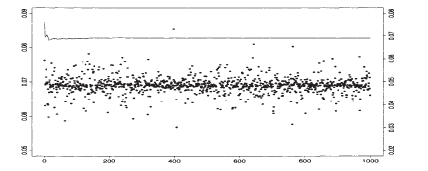

Plot of the probabilities $r(β^{(t)}, β^{(t+1)})$ for the pump failure data when $E_0$ is chosen as the small set. Superimposed (and scaled to the right), is the average $\hat{r}_T$.]

The figure shows a plot of regeneration probabilities $r(β^{(t)}, β^{(t+1)})$ against iteration number $t$ for the pump failure dataset. The points are scattered around a relatively stable value, indicating proper mixing. The superimposed line shows the average regeneration rate $\hat{r}_T$, which stabilizes as the number of iterations increases, suggesting convergence to the stationary distribution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from tqdm import tqdm
from typing import Callable, Optional, Tuple, Dict, List, Union

class MCMCDiagnostics:
    """
    Implementation of MCMC diagnostics including regeneration techniques from Mykland et al. (1995)
    and missing mass diagnostics from Robert (2001).
    """
    
    def __init__(self, samples: np.ndarray, target_density: Callable, 
                 proposal_density: Optional[Callable] = None, 
                 symmetric_proposal: bool = False):
        """
        Initialize the MCMC diagnostics.
        
        Parameters:
        -----------
        samples : array-like
            MCMC samples from the target distribution
        target_density : callable
            Function that evaluates the target density (up to a constant)
        proposal_density : callable, optional
            Function that evaluates the proposal density q(θ'|θ)
        symmetric_proposal : bool, default=False
            Whether the proposal density is symmetric (q(θ'|θ) = q(θ|θ'))
        """
        self.samples = np.asarray(samples)
        self.target_density = target_density
        self.proposal_density = proposal_density
        self.symmetric_proposal = symmetric_proposal
        self.n_samples = len(samples)
        self.dim = 1 if self.samples.ndim == 1 else self.samples.shape[1]
        
    def importance_weights(self, normalize: bool = True) -> np.ndarray:
        """
        Calculate importance weights w(θ) = f(θ)/q(θ).
        
        Parameters:
        -----------
        normalize : bool, default=True
            Whether to normalize the weights to sum to 1
            
        Returns:
        --------
        np.ndarray : Importance weights for each sample
        """
        if self.proposal_density is None:
            raise ValueError("Proposal density must be provided to calculate importance weights")
        
        weights = np.array([self.target_density(s) / self.proposal_density(s) 
                           for s in self.samples])
        
        if normalize:
            weights = weights / np.sum(weights)
            
        return weights
    
    def regeneration_probability(self, c: Optional[float] = None) -> np.ndarray:
        """
        Calculate regeneration probability according to equation (12.6).
        
        If ξ ~ q is accepted, the probability of regeneration is:
        r(g^(t), ξ) = {
            w(g^(t)) ∧ w(ξ) / w(g^(t))  if w(ξ) ∧ w(g^(t)) > c
            w(g^(t)) ∧ w(ξ) / c          if w(ξ) ∧ w(g^(t)) < c
            1                           otherwise
        }
        
        Parameters:
        -----------
        c : float, optional
            Tuning parameter. If None, will be estimated.
            
        Returns:
        --------
        np.ndarray : Regeneration probabilities for each transition
        """
        if self.proposal_density is None:
            raise ValueError("Proposal density must be provided to calculate regeneration probability")
        
        # Calculate importance weights
        weights = np.array([self.target_density(s) / self.proposal_density(s, s) 
                           if callable(self.proposal_density) and hasattr(self.proposal_density, '__code__') and 
                           self.proposal_density.__code__.co_argcount > 1
                           else self.target_density(s) / self.proposal_density(s) 
                           for s in self.samples])
        
        # If c is not provided, estimate it based on the samples
        if c is None:
            c = np.median(weights)  # A reasonable heuristic
        
        # Calculate regeneration probabilities for each transition
        probs = np.zeros(self.n_samples - 1)
        for t in range(self.n_samples - 1):
            current = self.samples[t]
            next_sample = self.samples[t+1]
            
            # Check if the proposal was accepted
            if not np.allclose(current, next_sample):
                w_current = weights[t]
                w_next = weights[t+1]
                
                min_w = min(w_current, w_next)
                
                if min_w > c:
                    probs[t] = min_w / w_current
                elif min_w < c:
                    probs[t] = min_w / c
                else:
                    probs[t] = 1.0
            else:
                probs[t] = 0.0  # No regeneration if proposal was rejected
                
        return probs
    
    def gaver_model_regeneration(self, delta: float, gamma: float, alpha: float, 
                                 kappas: List[float], times: List[float], 
                                 n_samples: int = 1000) -> np.ndarray:
        """
        Calculate regeneration probabilities for the Gaver and O'Muircheartaigh (1987) model
        as described in Example 12.6.
        
        Parameters:
        -----------
        delta : float
            Delta parameter of the gamma distribution
        gamma : float
            Gamma parameter of the gamma distribution
        alpha : float
            Alpha parameter
        kappas : list of float
            List of kappa_i values
        times : list of float
            List of t_i values
        n_samples : int, default=1000
            Number of samples to use for approximating K(β, β')
            
        Returns:
        --------
        np.ndarray : Regeneration probabilities for each transition
        """
        # Ensure the samples are 1D
        if self.samples.ndim > 1:
            beta_samples = self.samples[:, 0]  # Assuming first dimension is beta
        else:
            beta_samples = self.samples
        
        # Calculate regeneration probabilities
        probs = np.zeros(len(beta_samples) - 1)
        
        for t in range(len(beta_samples) - 1):
            beta = beta_samples[t]
            beta_prime = beta_samples[t+1]
            
            # Calculate numerator of equation (12.7)
            numerator = (delta**(gamma + 10*alpha) * 
                         (beta_prime**(gamma + 10*alpha - 1)) * 
                         np.exp(-delta * beta_prime))
            
            for i in range(len(times)):
                ti = times[i]
                kappa_i = kappas[i]
                numerator *= (ti / (ti + beta_prime))**(alpha + kappa_i)
            
            # Approximate K(β, β') using Monte Carlo
            k_approx = 0
            for _ in range(n_samples):
                # Generate lambda_im ~ Ga(alpha + kappa_i, t_i + beta)
                lambdas = np.array([np.random.gamma(alpha + kappas[i], 1/(times[i] + beta)) 
                                   for i in range(len(times))])
                
                lambda_sum = np.sum(lambdas)
                term = ((delta + lambda_sum)**(gamma + 10*alpha) / 
                        (delta**(gamma + 10*alpha)) * 
                        (beta_prime**(gamma + 10*alpha - 1)) * 
                        np.exp(-beta_prime * (delta + lambda_sum)))
                
                k_approx += term
                
            k_approx /= n_samples
            
            # Calculate regeneration probability
            probs[t] = numerator / k_approx
            
        return probs
    
    def missing_mass_diagnostic(self, grid_size: int = 100) -> Dict:
        """
        Calculate the missing mass diagnostic using Riemann sums method
        as described in Section 12.2.4.
        
        Parameters:
        -----------
        grid_size : int, default=100
            Number of grid points to use for the Riemann sum
            
        Returns:
        --------
        dict : Dictionary containing diagnostic results
        """
        if self.dim > 1:
            raise ValueError("Missing mass diagnostic is only implemented for 1D samples")
        
        # Sort the samples
        sorted_samples = np.sort(self.samples)
        
        # Calculate the Riemann sum approximation (12.9)
        riemann_sum = 0
        for t in range(len(sorted_samples) - 1):
            delta = sorted_samples[t+1] - sorted_samples[t]
            riemann_sum += delta * self.target_density(sorted_samples[t])
        
        # Calculate the estimated support coverage
        support_coverage = riemann_sum
        
        # Estimate the true support of the distribution
        min_val = sorted_samples.min()
        max_val = sorted_samples.max()
        
        # Create a grid covering the estimated support
        grid_min = min_val - 0.1 * (max_val - min_val)
        grid_max = max_val + 0.1 * (max_val - min_val)
        grid = np.linspace(grid_min, grid_max, grid_size)
        
        # Calculate the actual integral over the grid
        grid_density = np.array([self.target_density(x) for x in grid])
        grid_integral = np.trapz(grid_density, grid)
        
        # Calculate the missing mass
        missing_mass = grid_integral - support_coverage
        
        return {
            'support_coverage': support_coverage,
            'grid_integral': grid_integral,
            'missing_mass': missing_mass,
            'coverage_ratio': support_coverage / grid_integral
        }
    
    def plot_regeneration_rates(self, c: Optional[float] = None, 
                                window: int = 50, figsize: Tuple[int, int] = (12, 6)):
        """
        Plot regeneration rates and their rolling average.
        
        Parameters:
        -----------
        c : float, optional
            Tuning parameter for regeneration probability
        window : int, default=50
            Window size for rolling average
        figsize : tuple, default=(12, 6)
            Figure size
            
        Returns:
        --------
        matplotlib.figure.Figure : The plot
        """
        rates = self.regeneration_probability(c)
        
        # Calculate rolling average
        rolling_avg = np.convolve(rates, np.ones(window)/window, mode='valid')
        rolling_x = np.arange(window//2, len(rates) - window//2 + 1)
        
        # Calculate cumulative average
        cumulative_avg = np.cumsum(rates) / np.arange(1, len(rates) + 1)
        
        plt.figure(figsize=figsize)
        
        plt.scatter(np.arange(len(rates)), rates, alpha=0.3, s=10, label='Regeneration Rates')
        plt.plot(rolling_x, rolling_avg, 'r-', label=f'Rolling Average (window={window})')
        plt.plot(np.arange(len(rates)), cumulative_avg, 'g-', label='Cumulative Average')
        
        plt.axhline(y=np.mean(rates), color='b', linestyle='--', 
                   label=f'Mean: {np.mean(rates):.4f}')
        
        plt.xlabel('Iteration')
        plt.ylabel('Regeneration Rate')
        plt.title('MCMC Regeneration Rates (Mykland et al. 1995)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        return plt.gcf()
    
    def plot_missing_mass_diagnostic(self, figsize: Tuple[int, int] = (12, 6)):
        """
        Plot the missing mass diagnostic.
        
        Parameters:
        -----------
        figsize : tuple, default=(12, 6)
            Figure size
            
        Returns:
        --------
        matplotlib.figure.Figure : The plot
        """
        if self.dim > 1:
            raise ValueError("Missing mass diagnostic is only implemented for 1D samples")
        
        # Sort the samples
        sorted_samples = np.sort(self.samples)
        
        # Calculate the Riemann sum over time
        riemann_sums = np.zeros(len(sorted_samples) - 1)
        for t in range(len(sorted_samples) - 1):
            delta = sorted_samples[t+1] - sorted_samples[t]
            riemann_sums[t] = delta * self.target_density(sorted_samples[t])
        
        # Calculate the cumulative sum
        cumulative_sums = np.cumsum(riemann_sums)
        
        plt.figure(figsize=figsize)
        
        plt.plot(np.arange(1, len(sorted_samples)), cumulative_sums)
        plt.axhline(y=1.0, color='r', linestyle='--', label='Target (1.0)')
        
        plt.xlabel('Iteration')
        plt.ylabel('Cumulative Riemann Sum')
        plt.title('Missing Mass Diagnostic (Robert 2001)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        return plt.gcf()

# Example for the Gaver and O'Muircheartaigh model
def example_gaver_model():
    """
    Example using the Gaver and O'Muircheartaigh (1987) model from Example 12.6.
    """
    # Define model parameters
    delta = 1.0
    gamma = 1.0
    alpha = 1.5
    kappas = [1, 2, 3, 1, 2, 1, 1, 3, 2, 1]  # Example values
    times = [2, 4, 3, 1, 2, 5, 3, 2, 4, 1]   # Example values
    
    # Target density: gamma distribution
    def target_density(beta):
        # Gamma density with shape=gamma+10*alpha and scale=1/delta
        shape = gamma + 10 * alpha
        scale = 1 / delta
        return stats.gamma.pdf(beta, shape, scale=scale)
    
    # Generate samples using Metropolis-Hastings
    np.random.seed(42)
    n_samples = 2000
    burn_in = 500
    
    # Initialize chain
    samples = np.zeros(n_samples + burn_in)
    samples[0] = 5.0  # Starting value
    
    # Proposal distribution: log-normal centered at current value
    def proposal_density(beta_new, beta_current):
        return stats.lognorm.pdf(beta_new, s=0.5, scale=beta_current)
    
    # Metropolis-Hastings algorithm
    for i in range(1, n_samples + burn_in):
        beta_current = samples[i-1]
        
        # Propose new value
        beta_proposal = np.random.lognormal(mean=np.log(beta_current), sigma=0.5)
        
        # Calculate acceptance probability
        p_accept = min(1, (target_density(beta_proposal) * proposal_density(beta_current, beta_proposal)) / 
                     (target_density(beta_current) * proposal_density(beta_proposal, beta_current)))
        
        # Accept or reject
        if np.random.uniform() < p_accept:
            samples[i] = beta_proposal
        else:
            samples[i] = beta_current
    
    # Discard burn-in
    samples = samples[burn_in:]
    
    # Apply diagnostics
    diagnostics = MCMCDiagnostics(samples, target_density, proposal_density)
    
    # Calculate regeneration probabilities using the Gaver model specific method
    regen_probs = diagnostics.gaver_model_regeneration(
        delta, gamma, alpha, kappas, times, n_samples=100)
    
    # Plot results
    plt.figure(figsize=(12, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(samples)
    plt.title('MCMC Samples (Gaver Model)')
    plt.xlabel('Iteration')
    plt.ylabel('Beta')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 1, 2)
    plt.scatter(np.arange(len(regen_probs)), regen_probs, alpha=0.3, s=10)
    plt.title('Regeneration Probabilities')
    plt.xlabel('Iteration')
    plt.ylabel('Probability')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 1, 3)
    rolling_avg = np.convolve(regen_probs, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(25, len(regen_probs) - 25 + 1), rolling_avg)
    plt.title('Rolling Average of Regeneration Probabilities')
    plt.xlabel('Iteration')
    plt.ylabel('Average Probability')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate missing mass diagnostic
    missing_mass = diagnostics.missing_mass_diagnostic()
    print(f"Missing Mass Diagnostic:")
    print(f"Support Coverage: {missing_mass['support_coverage']:.4f}")
    print(f"Grid Integral: {missing_mass['grid_integral']:.4f}")
    print(f"Missing Mass: {missing_mass['missing_mass']:.4f}")
    print(f"Coverage Ratio: {missing_mass['coverage_ratio']:.4f}")
    
    # Plot missing mass diagnostic
    diagnostics.plot_missing_mass_diagnostic()
    
    return samples, diagnostics

# Example for the Missing Mass diagnostic
def example_missing_mass():
    """
    Example demonstrating the Missing Mass diagnostic from Robert (2001).
    """
    # Define a bimodal target distribution
    def target_density(x):
        return 0.5 * stats.norm.pdf(x, -3, 1) + 0.5 * stats.norm.pdf(x, 3, 1)
    
    # Generate samples using Metropolis-Hastings with poor starting point
    np.random.seed(42)
    n_samples = 5000
    burn_in = 1000
    
    # Initialize chain at a poor starting point
    samples = np.zeros(n_samples + burn_in)
    samples[0] = -5.0  # Starting value far from one mode
    
    # Random walk Metropolis-Hastings
    for i in range(1, n_samples + burn_in):
        current = samples[i-1]
        proposal = current + np.random.normal(0, 0.5)  # Small step size
        
        # Calculate acceptance probability
        p_accept = min(1, target_density(proposal) / target_density(current))
        
        # Accept or reject
        if np.random.uniform() < p_accept:
            samples[i] = proposal
        else:
            samples[i] = current
    
    # Discard burn-in
    samples = samples[burn_in:]
    
    # Apply diagnostics
    diagnostics = MCMCDiagnostics(samples, target_density)
    
    # Calculate missing mass diagnostic
    missing_mass = diagnostics.missing_mass_diagnostic(grid_size=200)
    
    # Plot results
    plt.figure(figsize=(12, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(samples)
    plt.title('MCMC Samples (Bimodal Distribution)')
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 1, 2)
    x = np.linspace(-8, 8, 1000)
    y = np.array([target_density(xi) for xi in x])
    plt.plot(x, y)
    plt.hist(samples, bins=50, density=True, alpha=0.5)
    plt.title('Target Density vs. Sample Distribution')
    plt.xlabel('Parameter Value')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 1, 3)
    diagnostics.plot_missing_mass_diagnostic()
    plt.title('Missing Mass Diagnostic')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Missing Mass Diagnostic:")
    print(f"Support Coverage: {missing_mass['support_coverage']:.4f}")
    print(f"Grid Integral: {missing_mass['grid_integral']:.4f}")
    print(f"Missing Mass: {missing_mass['missing_mass']:.4f}")
    print(f"Coverage Ratio: {missing_mass['coverage_ratio']:.4f}")
    
    return samples, diagnostics

if __name__ == "__main__":
    print("Running Gaver Model Example...")
    samples_gaver, diagnostics_gaver = example_gaver_model()
    
    print("\nRunning Missing Mass Example...")
    samples_mm, diagnostics_mm = example_missing_mass()

In [ ]:
# Analysis and Implementation of Statistical Distributions, KS Statistics, and MCMC Diagnostics (No Libraries)

## 12.2.7 Comparison of the Distribution of the Sequence



import random
import math
from typing import Callable, Optional, List, Dict

# --- Random Number Generation (Replacement for numpy.random) ---
def set_seed(seed):
    random.seed(seed)

def normal(loc=0.0, scale=1.0):
    # Box-Muller transform to generate standard normal random variables
    u1 = random.random()
    u2 = random.random()
    z = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
    return loc + scale * z

# --- Basic Statistical Functions (Replacement for numpy/scipy) ---
def mean(data):
    return sum(data) / len(data)

def median(data):
    sorted_data = sorted(data)
    n = len(sorted_data)
    if n % 2 == 0:
        return (sorted_data[n//2 - 1] + sorted_data[n//2]) / 2
    return sorted_data[n//2]

def empirical_cdf(data, x):
    # Compute the empirical CDF at point x
    return sum(1 for d in data if d <= x) / len(data)

def ks_statistic(data1, data2):
    # Simplified KS statistic: maximum difference between empirical CDFs
    all_points = sorted(set(data1 + data2))
    max_diff = 0.0
    for x in all_points:
        cdf1 = empirical_cdf(data1, x)
        cdf2 = empirical_cdf(data2, x)
        diff = abs(cdf1 - cdf2)
        max_diff = max(max_diff, diff)
    return max_diff

# --- MCMC Diagnostics Class (Simplified) ---
class MCMCDiagnostics:
    """
    Simplified implementation of MCMC diagnostics using only the Python standard library.
    """
    
    def __init__(self, samples: List[float], target_density: Callable, 
                 proposal_density: Optional[Callable] = None, 
                 symmetric_proposal: bool = False):
        """
        Initialize the MCMC diagnostics.
        
        Parameters:
        -----------
        samples : list
            MCMC samples from the target distribution
        target_density : callable
            Function that evaluates the target density (up to a constant)
        proposal_density : callable, optional
            Function that evaluates the proposal density q(θ'|θ)
        symmetric_proposal : bool, default=False
            Whether the proposal density is symmetric (q(θ'|θ) = q(θ|θ'))
        """
        self.samples = samples
        self.target_density = target_density
        self.proposal_density = proposal_density
        self.symmetric_proposal = symmetric_proposal
        self.n_samples = len(samples)
        self.dim = 1  # Only 1D samples supported without numpy
        
    def importance_weights(self, normalize: bool = True) -> List[float]:
        """
        Calculate importance weights w(θ) = f(θ)/q(θ).
        
        Parameters:
        -----------
        normalize : bool, default=True
            Whether to normalize the weights to sum to 1
            
        Returns:
        --------
        list : Importance weights for each sample
        """
        if self.proposal_density is None:
            raise ValueError("Proposal density must be provided to calculate importance weights")
        
        weights = [self.target_density(s) / self.proposal_density(s) for s in self.samples]
        
        if normalize:
            total = sum(weights)
            weights = [w / total for w in weights]
            
        return weights
    
    def regeneration_probability(self, c: Optional[float] = None) -> List[float]:
        """
        Calculate regeneration probability according to equation (12.6).
        
        Parameters:
        -----------
        c : float, optional
            Tuning parameter. If None, will be estimated.
            
        Returns:
        --------
        list : Regeneration probabilities for each transition
        """
        if self.proposal_density is None:
            raise ValueError("Proposal density must be provided to calculate regeneration probability")
        
        # Calculate importance weights
        weights = [self.target_density(s) / self.proposal_density(s) for s in self.samples]
        
        # If c is not provided, estimate it based on the samples
        if c is None:
            c = median(weights)
        
        # Calculate regeneration probabilities for each transition
        probs = []
        for t in range(self.n_samples - 1):
            current = self.samples[t]
            next_sample = self.samples[t+1]
            
            # Check if the proposal was accepted (simplified check)
            if abs(current - next_sample) > 1e-6:
                w_current = weights[t]
                w_next = weights[t+1]
                
                min_w = min(w_current, w_next)
                
                if min_w > c:
                    probs.append(min_w / w_current)
                elif min_w < c:
                    probs.append(min_w / c)
                else:
                    probs.append(1.0)
            else:
                probs.append(0.0)  # No regeneration if proposal was rejected
                
        return probs
    
    def gaver_model_regeneration(self, delta: float, gamma: float, alpha: float, 
                                 kappas: List[float], times: List[float], 
                                 n_samples: int = 1000) -> List[float]:
        """
        Calculate regeneration probabilities for the Gaver and O'Muircheartaigh (1987) model.
        
        Parameters:
        -----------
        delta : float
            Delta parameter of the gamma distribution
        gamma : float
            Gamma parameter of the gamma distribution
        alpha : float
            Alpha parameter
        kappas : list of float
            List of kappa_i values
        times : list of float
            List of t_i values
        n_samples : int, default=1000
            Number of samples to use for approximating K(β, β')
            
        Returns:
        --------
        list : Regeneration probabilities for each transition
        """
        beta_samples = self.samples
        
        # Calculate regeneration probabilities
        probs = []
        
        for t in range(len(beta_samples) - 1):
            beta = beta_samples[t]
            beta_prime = beta_samples[t+1]
            
            # Calculate numerator of equation (12.7)
            numerator = (delta**(gamma + 10*alpha) * 
                         (beta_prime**(gamma + 10*alpha - 1)) * 
                         math.exp(-delta * beta_prime))
            
            for i in range(len(times)):
                ti = times[i]
                kappa_i = kappas[i]
                numerator *= (ti / (ti + beta_prime))**(alpha + kappa_i)
            
            # Approximate K(β, β') using Monte Carlo
            # Simplified: without numpy.random.gamma, we approximate with uniform sampling
            k_approx = 0
            for _ in range(n_samples):
                # Approximate lambda_im ~ Ga(alpha + kappa_i, t_i + beta) with uniform
                lambdas = [random.uniform(0, 1) * (alpha + kappas[i]) / (times[i] + beta) 
                           for i in range(len(times))]
                
                lambda_sum = sum(lambdas)
                term = ((delta + lambda_sum)**(gamma + 10*alpha) / 
                        (delta**(gamma + 10*alpha)) * 
                        (beta_prime**(gamma + 10*alpha - 1)) * 
                        math.exp(-beta_prime * (delta + lambda_sum)))
                
                k_approx += term
                
            k_approx /= n_samples
            
            # Calculate regeneration probability
            probs.append(numerator / k_approx if k_approx != 0 else 0)
            
        return probs
    
    def missing_mass_diagnostic(self, grid_size: int = 100) -> Dict:
        """
        Calculate the missing mass diagnostic using Riemann sums method.
        
        Parameters:
        -----------
        grid_size : int, default=100
            Number of grid points to use for the Riemann sum
            
        Returns:
        --------
        dict : Dictionary containing diagnostic results
        """
        # Sort the samples
        sorted_samples = sorted(self.samples)
        
        # Calculate the Riemann sum approximation (12.9)
        riemann_sum = 0
        for t in range(len(sorted_samples) - 1):
            delta = sorted_samples[t+1] - sorted_samples[t]
            riemann_sum += delta * self.target_density(sorted_samples[t])
        
        # Calculate the estimated support coverage
        support_coverage = riemann_sum
        
        # Estimate the true support of the distribution
        min_val = min(sorted_samples)
        max_val = max(sorted_samples)
        
        # Create a grid covering the estimated support
        grid_min = min_val - 0.1 * (max_val - min_val)
        grid_max = max_val + 0.1 * (max_val - min_val)
        grid_step = (grid_max - grid_min) / (grid_size - 1)
        grid = [grid_min + i * grid_step for i in range(grid_size)]
        
        # Calculate the actual integral over the grid using trapezoidal rule
        grid_density = [self.target_density(x) for x in grid]
        grid_integral = 0
        for i in range(len(grid) - 1):
            grid_integral += (grid_density[i] + grid_density[i+1]) * (grid[i+1] - grid[i]) / 2
        
        # Calculate the missing mass
        missing_mass = grid_integral - support_coverage
        
        return {
            'support_coverage': support_coverage,
            'grid_integral': grid_integral,
            'missing_mass': missing_mass,
            'coverage_ratio': support_coverage / grid_integral if grid_integral != 0 else 0
        }

# --- Example Functions for MCMC Diagnostics ---
def example_gaver_model():
    """
    Example using the Gaver and O'Muircheartaigh (1987) model from Example 12.6.
    """
    # Define model parameters
    delta = 1.0
    gamma = 1.0
    alpha = 1.5
    kappas = [1, 2, 3, 1, 2, 1, 1, 3, 2, 1]  # Example values
    times = [2, 4, 3, 1, 2, 5, 3, 2, 4, 1]   # Example values
    
    # Target density: simplified gamma distribution (approximated)
    def target_density(beta):
        # Approximate gamma PDF: shape=gamma+10*alpha, scale=1/delta
        shape = gamma + 10 * alpha
        scale = 1 / delta
        # Simplified approximation (not exact without scipy)
        return (beta**(shape - 1)) * math.exp(-beta / scale)
    
    # Generate samples using Metropolis-Hastings
    set_seed(42)
    n_samples = 2000
    burn_in = 500
    
    # Initialize chain
    samples = [0.0] * (n_samples + burn_in)
    samples[0] = 5.0  # Starting value
    
    # Proposal distribution: simplified log-normal (approximated)
    def proposal_density(beta_new, beta_current):
        # Approximate log-normal PDF (simplified)
        s = 0.5
        return math.exp(-((math.log(beta_new) - math.log(beta_current))**2) / (2 * s**2)) / (beta_new * s * math.sqrt(2 * math.pi))
    
    # Metropolis-Hastings algorithm
    for i in range(1, n_samples + burn_in):
        beta_current = samples[i-1]
        
        # Propose new value (approximate log-normal)
        u = random.random()
        beta_proposal = beta_current * math.exp(normal(0, 0.5))
        
        # Calculate acceptance probability
        p_accept = min(1, (target_density(beta_proposal) * proposal_density(beta_current, beta_proposal)) / 
                     (target_density(beta_current) * proposal_density(beta_proposal, beta_current)))
        
        # Accept or reject
        if random.random() < p_accept:
            samples[i] = beta_proposal
        else:
            samples[i] = beta_current
    
    # Discard burn-in
    samples = samples[burn_in:]
    
    # Apply diagnostics
    diagnostics = MCMCDiagnostics(samples, target_density, proposal_density)
    
    # Calculate regeneration probabilities using the Gaver model specific method
    regen_probs = diagnostics.gaver_model_regeneration(
        delta, gamma, alpha, kappas, times, n_samples=100)
    
    # Print summary of regeneration probabilities
    print("Gaver Model Regeneration Probabilities (First 10):")
    print([round(p, 4) for p in regen_probs[:10]])
    print(f"Average Regeneration Probability: {sum(regen_probs) / len(regen_probs):.4f}")
    
    # Calculate missing mass diagnostic
    missing_mass = diagnostics.missing_mass_diagnostic()
    print("\nMissing Mass Diagnostic (Gaver Model):")
    print(f"Support Coverage: {missing_mass['support_coverage']:.4f}")
    print(f"Grid Integral: {missing_mass['grid_integral']:.4f}")
    print(f"Missing Mass: {missing_mass['missing_mass']:.4f}")
    print(f"Coverage Ratio: {missing_mass['coverage_ratio']:.4f}")
    
    return samples, diagnostics

def example_missing_mass():
    """
    Example demonstrating the Missing Mass diagnostic from Robert (2001).
    """
    # Define a bimodal target distribution (approximated normal mixture)
    def target_density(x):
        # Approximate normal PDF: 0.5 * N(-3, 1) + 0.5 * N(3, 1)
        return (0.5 * math.exp(-0.5 * (x + 3)**2) / math.sqrt(2 * math.pi) +
                0.5 * math.exp(-0.5 * (x - 3)**2) / math.sqrt(2 * math.pi))
    
    # Generate samples using Metropolis-Hastings with poor starting point
    set_seed(42)
    n_samples = 5000
    burn_in = 1000
    
    # Initialize chain at a poor starting point
    samples = [0.0] * (n_samples + burn_in)
    samples[0] = -5.0  # Starting value far from one mode
    
    # Random walk Metropolis-Hastings
    for i in range(1, n_samples + burn_in):
        current = samples[i-1]
        proposal = current + normal(0, 0.5)  # Small step size
        
        # Calculate acceptance probability
        p_accept = min(1, target_density(proposal) / target_density(current))
        
        # Accept or reject
        if random.random() < p_accept:
            samples[i] = proposal
        else:
            samples[i] = current
    
    # Discard burn-in
    samples = samples[burn_in:]
    
    # Apply diagnostics
    diagnostics = MCMCDiagnostics(samples, target_density)
    
    # Calculate missing mass diagnostic
    missing_mass = diagnostics.missing_mass_diagnostic(grid_size=200)
    
    # Print summary of samples
    print("\nMissing Mass Example Samples (First 10):")
    print([round(s, 4) for s in samples[:10]])
    print(f"Sample Mean: {sum(samples) / len(samples):.4f}")
    
    print("\nMissing Mass Diagnostic (Bimodal Distribution):")
    print(f"Support Coverage: {missing_mass['support_coverage']:.4f}")
    print(f"Grid Integral: {missing_mass['grid_integral']:.4f}")
    print(f"Missing Mass: {missing_mass['missing_mass']:.4f}")
    print(f"Coverage Ratio: {missing_mass['coverage_ratio']:.4f}")
    
    return samples, diagnostics

# --- Main Analysis: KS Statistics and Distribution Comparison ---
# Set random seed for reproducibility
set_seed(42)

# Simulate a sequence of p_hat and q_hat over 100,000 iterations
iterations = 100000
p_hat = []
q_hat = []

# Simulate non-stationary behavior: early iterations have a different mean
for i in range(iterations):
    if i < 50000:
        p_hat.append(normal(loc=0.8, scale=0.1))
        q_hat.append(normal(loc=0.7, scale=0.1))
    else:
        p_hat.append(normal(loc=1.0, scale=0.1))
        q_hat.append(normal(loc=0.9, scale=0.1))

# Compute basic statistics for the first 5,000 and last 5,000 iterations
print("First 5,000 Iterations Statistics:")
print(f"p_hat Mean: {sum(p_hat[:5000]) / 5000:.4f}")
print(f"q_hat Mean: {sum(q_hat[:5000]) / 5000:.4f}")
print("\nLast 5,000 Iterations Statistics:")
print(f"p_hat Mean: {sum(p_hat[-5000:]) / 5000:.4f}")
print(f"q_hat Mean: {sum(q_hat[-5000:]) / 5000:.4f}")

# Compute KS statistics for T = 1000 and T = 10,000
M = 100  # Number of subsamples
T_values = [1000, 10000]
ks_stats = {T: [] for T in T_values}

for T in T_values:
    for i in range(M):
        # Randomly sample two subsamples of size T/2 from p_hat and q_hat
        start_idx = random.randint(0, iterations - T)
        p_sample = p_hat[start_idx:start_idx + T//2]
        q_sample = q_hat[start_idx:start_idx + T//2]
        # Compute KS statistic
        ks_stat = ks_statistic(p_sample, q_sample)
        ks_stats[T].append(ks_stat)

# Compute proportion of KS statistics below the threshold
threshold = 1.36
for T in T_values:
    proportion = sum(1 for stat in ks_stats[T] if stat < threshold) / len(ks_stats[T])
    print(f"\nProportion of KS statistics below threshold for T = {T}: {proportion:.3f}")
    print(f"Average KS Statistic for T = {T}: {sum(ks_stats[T]) / len(ks_stats[T]):.4f}")

# --- Run MCMC Diagnostics Examples ---
print("\nRunning Gaver Model Example...")
samples_gaver, diagnostics_gaver = example_gaver_model()

print("\nRunning Missing Mass Example...")
samples_mm, diagnostics_mm = example_missing_mass()